# __Trabajando con redes neuronales y Deep Learning (Regresión)__
En el siguiente codigo exploraremos un dataset provisto al igual que aplicaremos diferentes algoritmos para lograr extraer conocimiento del mismo. De antemano cualquier duda no dude en [contactarme](mailto:ilgaleanos@gmail.com)

## __1. Importamos las librerias__

Importamos primero las librerias para tenerlas ordenadas y no reimportar librerias por todo el código.

In [1]:
# utiles de python para apoyarnos al escribir
from itertools import cycle
from collections import defaultdict

# librerias de soporte
import numpy as np
import pandas as pd
import pickle

# librerias para graficar
from matplotlib import pyplot
import matplotlib.pyplot as plt

# importamos de sklearn lo que utilizaremos
from sklearn import tree
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [2]:
import random
import math
import tensorflow as tf
import joblib
from pandas import read_csv
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras import activations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, AveragePooling1D, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib.backends.backend_pdf import FigureCanvasPdf, PdfPages
from matplotlib.figure import Figure
import numpy as np

## 2. Exploracion del dataset

En esta fase realizo observaciones específicas sobre el dataset para familiarizarnos con el y detectar anomalias. Una previa revisión nos hace darnos cuenta que es compuesto por columnas categóricas y se realiza su importacion teniendo en cuenta que es un csv pero separado por ','

### A. Observaciones: cantidades de nulos y tipos

No tenemos celdas nulas en ninguno de los campos lo cual nos da de primera mano buenos indicios de la calidad del dataset.

In [3]:
# según las indicaciones y la url de un repositorio público de github, importo los datos de dicha ruta
# tendremos en cuenta que estan separados los registros por ','


data = pd.read_csv("./procesado/PIB_1K+.csv", sep=',')
data = data[(data['PIB'] > 9000)]
print(data)
data.info(verbose=True)

         PIB  PARTICIPACIONES      REGALIAS  URIEL_CENSO_ELECT  \
57     14436     1.060639e+10  442522282167              18493   
58     10249     2.212104e+10  500190793156              34467   
60      9563     1.955605e+10  453584723884              28044   
1100   18285     5.335779e+11  113657120037             732774   
1101   22539     7.081414e+11  187066787257             796967   
1102   19766     5.828249e+11  127858463464             732774   
1103   15596     4.689886e+11  144086025059             692236   
1104   20960     6.264573e+11  106867389099             750215   
1105   16557     4.732668e+11  126875085044             719151   
1719    9204     6.489204e+10   20505827242             240189   
1735   45551     8.916536e+11    1703400501            1484784   
1736   59975     1.184246e+12    8892093747            1662854   
1737   55082     1.052479e+12             0            1588150   
1738   43042     8.539805e+11   15421841705            1412441   
1739   490

In [4]:
data['PARTICIPACIONES'].fillna(value=data['PARTICIPACIONES'].mean(), inplace=True)
data['HOMICIDIOSx100K_HAB'].fillna(value=data['HOMICIDIOSx100K_HAB'].mean(), inplace=True)

In [5]:
print(data["URIEL_DEL_ELECT"].mean())
print(data["URIEL_DEL_ELECT"].std())

109.11111111111111
166.24163987486057


### D. Agregación

A continuación sumamos la cantidad de valores de cada categoría para cada columna. De manera que las observaremos a nivel de conteo, en una gráfica de barras y las estadísticas de las columnas numéricas en un diagramas de cajas.

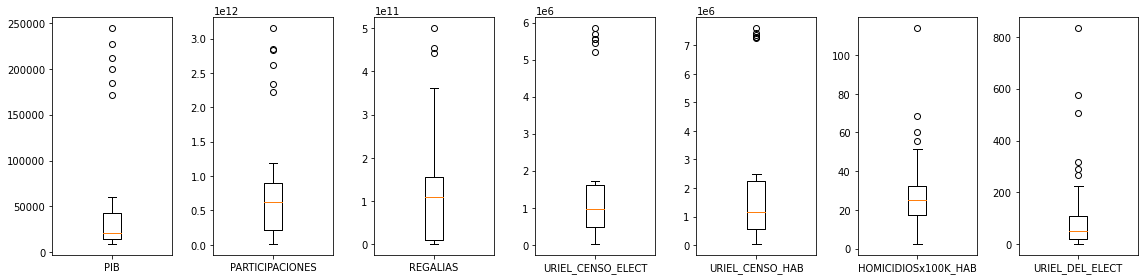

In [6]:
# Graficamos las variables continueas en diagramas de cajas para poder observar su distribución
# darnos una idea aún mas precisa de su distribución, en ello apreciamos que age y children están bastante
# bien distribuidos alrededor de su mediana más sin embargo charges tiene muchos anómalos. 
# bmi tiene anómalos pero en menor medida. Esto nos indica que, dado que la variable que queremos modelar
# con al regresion es charges, el problema no será sencillo
    
fig, axs = plt.subplots(1, 7, sharey=False, tight_layout=True, figsize=(16,4))

columnas_numericas = data.columns
for i in range(len(columnas_numericas)):
    axs[i].boxplot(data[columnas_numericas[i]], labels=[columnas_numericas[i]])

## 3. Proceso de Regresión

### A. Codificación de los datos

Realizamos un proceso para codificar los datos primero los transformaremos en numeros y a esta matriz la llamaremos __datos_listos__.

In [7]:
datos_listos = data.copy()

datos_listos

,PIB,PARTICIPACIONES,REGALIAS,URIEL_CENSO_ELECT,URIEL_CENSO_HAB,HOMICIDIOSx100K_HAB,URIEL_DEL_ELECT
57,14436,1.060639e+10,442522282167,18493,37091,113.880000,1
58,10249,2.212104e+10,500190793156,34467,42677,2.343183,99
60,9563,1.955605e+10,453584723884,28044,41513,15.870000,39
1100,18285,5.335779e+11,113657120037,732774,945316,25.360000,2
1101,22539,7.081414e+11,187066787257,796967,1003685,19.627672,58
1102,19766,5.828249e+11,127858463464,732774,956464,25.860000,39
1103,15596,4.689886e+11,144086025059,692236,927832,30.600000,71
1104,20960,6.264573e+11,106867389099,750215,973045,22.200000,125
1105,16557,4.732668e+11,126875085044,719151,935887,28.950000,41
1719,9204,6.489204e+10,20505827242,240189,236114,4.235242,32


In [8]:
# Normalizamos los columnas numéricas con un min max scaler

x = datos_listos.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
datos_listos = pd.DataFrame(x_scaled)
pickle.dump(min_max_scaler, open('escala.pickle.sav', 'wb'))
datos_listos

,0,1,2,3,4,5,6
0,0.023052,0.000000,0.884707,0.000000,0.000000,1.000000,0.000000
1,0.005251,0.003668,1.000000,0.002741,0.000739,0.000000,0.117788
2,0.002334,0.002851,0.906823,0.001639,0.000585,0.121277,0.045673
3,0.039416,0.166577,0.227228,0.122562,0.120203,0.206361,0.001202
4,0.057502,0.222178,0.373991,0.133576,0.127928,0.154967,0.068510
5,0.045712,0.182263,0.255619,0.122562,0.121678,0.210844,0.045673
6,0.027984,0.146004,0.288062,0.115606,0.117889,0.253341,0.084135
7,0.050789,0.196160,0.213653,0.125554,0.123873,0.178029,0.149038
8,0.032069,0.147366,0.253653,0.120224,0.118955,0.238547,0.048077
9,0.000808,0.017291,0.040996,0.038040,0.026340,0.016964,0.037260


In [9]:
# Separamos entrenamiento 80% y test 20% y separamos adicionalmente la ultima columna charges para modelar

X = datos_listos.iloc[:,:-1]
y = datos_listos[6].values
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, y, test_size=0.1, random_state=0, shuffle=True
)

eje_x = list(range(len(Y_validation)))

### B. Regresión lineal y por árboles

Probamos  los modelos de regresion lineal, regresion con árboles de decisión y por random forest.

Puntuacion Train: 0.158 RMSE  y Puntuacion Test: 0.06 RMSE
media 0.02372731308862164
desviacion 0.05201166396033902


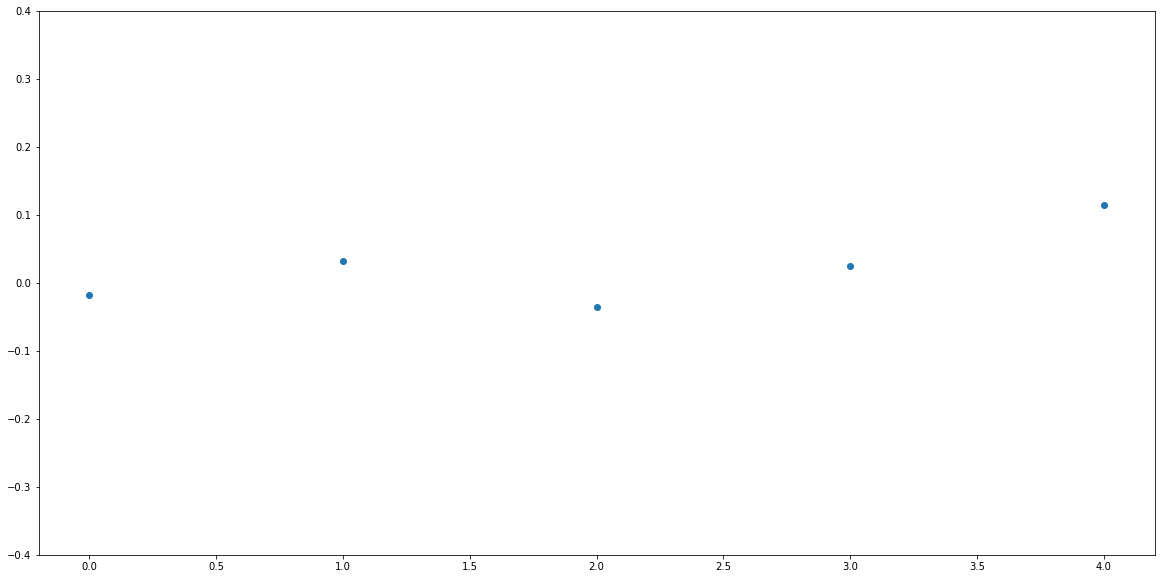

In [10]:
# Probamos un modelo de regresion lineal y calculamos su error cuadrático medio

lr = LinearRegression()
lr.fit(X_train, Y_train)
pickle.dump(lr, open('LinearRegression.pickle.sav', 'wb'))
Puntuacion_Train = math.sqrt(mean_squared_error(Y_train, lr.predict(X_train)))
Puntuacion_Test = math.sqrt(mean_squared_error(Y_validation, lr.predict(X_validation)))

residuos = lr.predict(X_validation) - Y_validation
print('Puntuacion Train: %.3f RMSE  y Puntuacion Test: %.2f RMSE' % (Puntuacion_Train, Puntuacion_Test))
print('media', np.mean(residuos))
print('desviacion', np.std(residuos))

# Graficamos los residuos de la regresión
plt.figure(figsize=(20,10))
plt.ylim([-0.4, 0.4])
plt.scatter(eje_x, lr.predict(X_validation) - Y_validation)

media 0.009963942307692295
desviacion 0.024833284028790578
Puntuacion Train: 0.077 RMSE  y Puntuacion Test: 0.03 RMSE
media -0.05841346153846154
desviacion 0.022963966338592295
Puntuacion Train: 0.000 RMSE  y Puntuacion Test: 0.06 RMSE


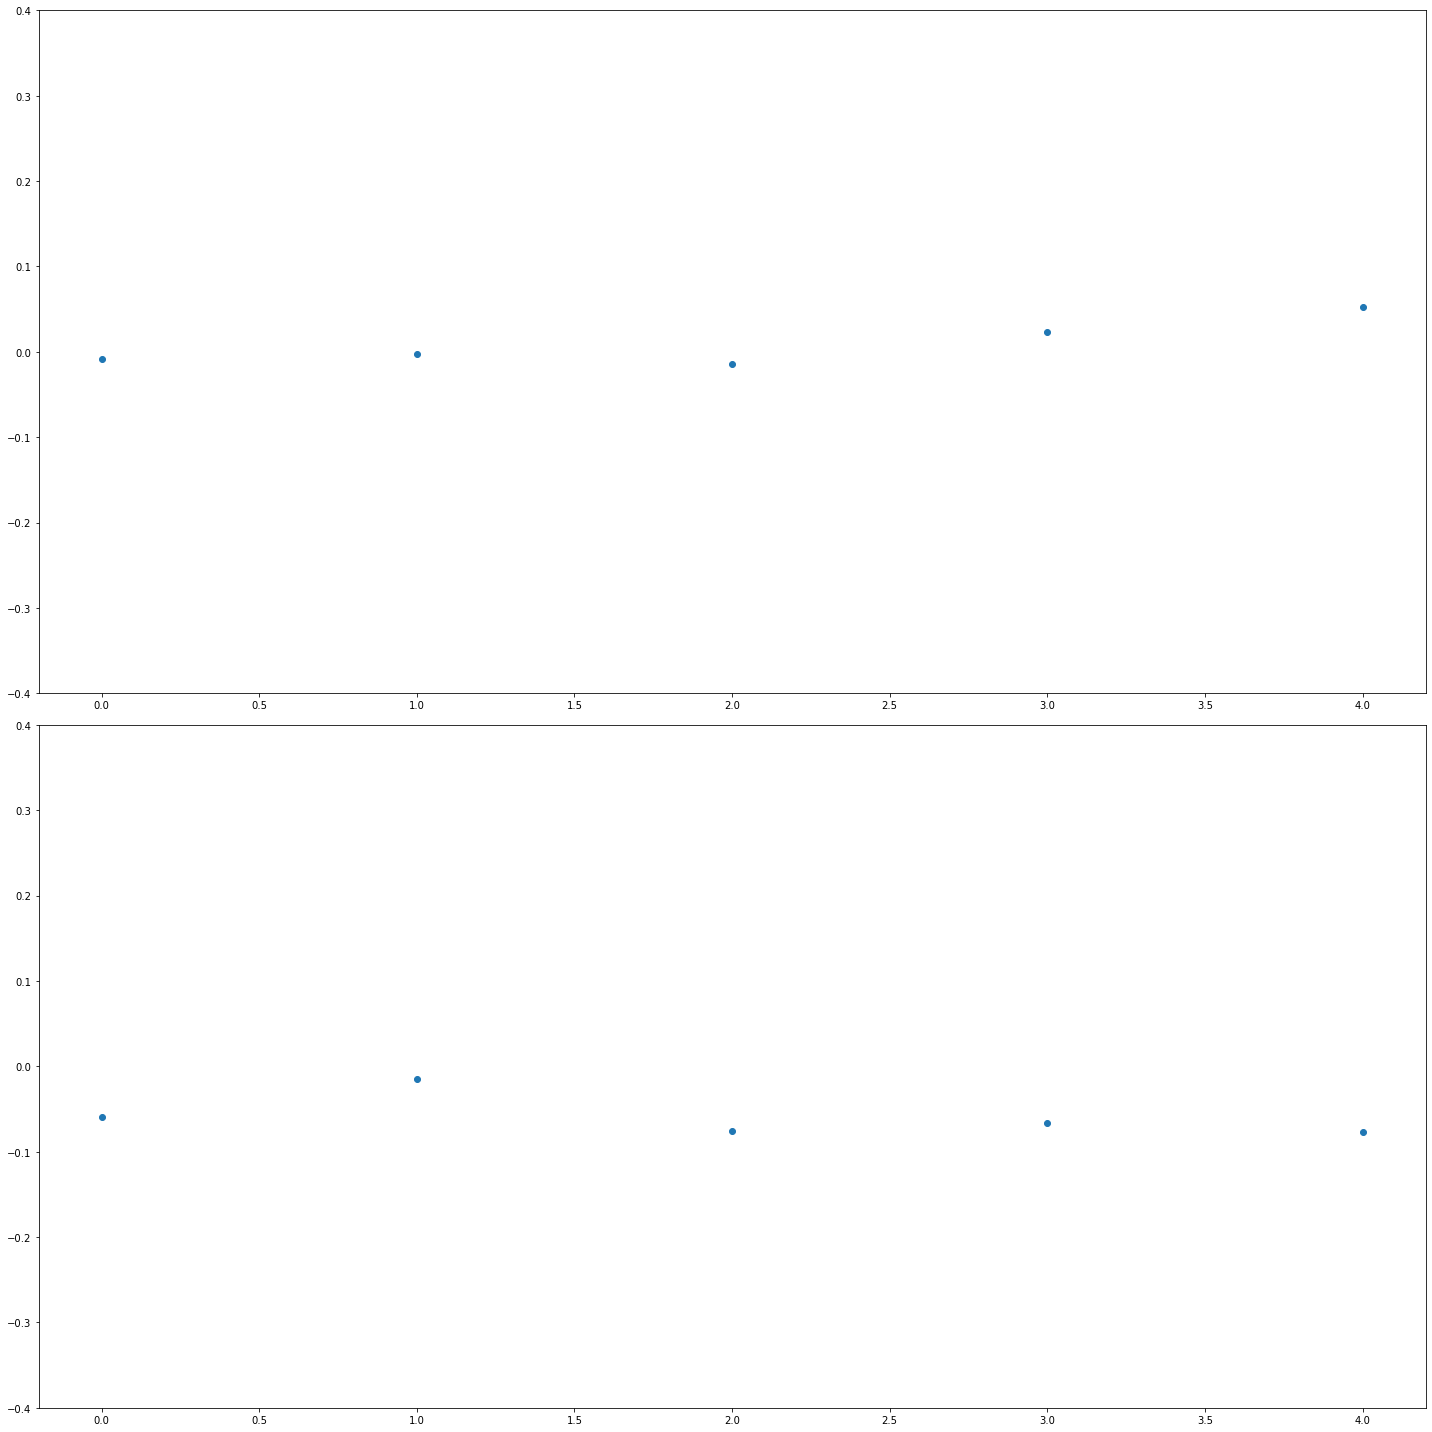

In [11]:
# Probamos los modelos de regresion para DecisionTree y RandomForest
# para ambos modelos probamos los criterios de error cuadrático medio
# Son bastante aceptables los resultados de Random Forest

models = []
models.append(('RF_mse', RandomForestRegressor(random_state=0, criterion="squared_error")))
models.append(('DR_mse', DecisionTreeRegressor(random_state=0, criterion="squared_error")))

eje_x = list(range(len(Y_validation)))
fig, axs = plt.subplots(2, sharey=False, tight_layout=True, figsize=(20,20))

results = []
names = []

# entrenamos cada modelo
contador = 0
for name, model in models:
    dt_fit = model.fit(X_train, Y_train)
    axs[contador].set_ylim([-0.4, 0.4])
    axs[contador].scatter(eje_x, dt_fit.predict(X_validation)-Y_validation)
    Puntuacion_Train = math.sqrt(mean_squared_error(Y_train, dt_fit.predict(X_train)))
    residuos = model.predict(X_validation) - Y_validation
    print('media', np.mean(residuos))
    print('desviacion', np.std(residuos))
    Puntuacion_Test = math.sqrt(mean_squared_error(Y_validation, dt_fit.predict(X_validation)))
    print('Puntuacion Train: %.3f RMSE  y Puntuacion Test: %.2f RMSE' % (Puntuacion_Train, Puntuacion_Test))
    contador += 1

### C. Redes neuronales
A Continuacion probaremos darle solucion al problema con una red neural de 4 capas ocultas

In [11]:
# cambiamos la forma de los train set para entrenar la red

X_train_ = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_validation_ = np.reshape(X_validation.values, (X_validation.shape[0], 1, X_validation.shape[1]))

print(X_train_.shape)
print(X_validation_.shape)

(2276, 1, 6)
(253, 1, 6)


In [12]:
# Creacion de Red con LSTM modelo compuesto 314
entradas = Input(shape=(1, (6) ))

a = Conv1D(5, kernel_size=(2), padding='same') (entradas)
a = MaxPooling1D(pool_size=(1), strides=(1), name='blocka') (a)
b = Conv1D(5, kernel_size=(3), padding='same') (entradas)
b = MaxPooling1D(pool_size=(1), strides=(1), name='blockb') (b)
c = Conv1D(5, kernel_size=(4), padding='same') (entradas)
c = MaxPooling1D(pool_size=(1), strides=(1), name='blockc') (c)

f = tf.keras.layers.Concatenate(axis=1)([ a, b, c])
f = Conv1D(5, kernel_size=(3), padding='same') (f)
x = AveragePooling1D(name='blockf') (f)

x_0 = GRU(10, return_sequences=True, activation=keras.activations.tanh, dropout=0.2) (x)
x_1 = GRU(10, return_sequences=True, activation=keras.activations.tanh, dropout=0.2) (a)
x_2 = GRU(10, return_sequences=True, activation=keras.activations.tanh, dropout=0.2) (b)
x_3 = GRU(10, return_sequences=True, activation=keras.activations.tanh, dropout=0.2) (c)

x = tf.keras.layers.Concatenate(axis=1)([x_0, x_1, x_2, x_3])
x = GRU(10, activation=keras.activations.sigmoid) (x)

x = Dense(1, activation=keras.activations.sigmoid) (x)
modelo = Model(inputs=entradas, outputs=x)
modelo.compile(loss=keras.losses.mse, optimizer=Adam(), metrics=['mse', 'accuracy'])

modelo.summary()

2022-02-14 21:05:50.571161: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-14 21:05:50.571795: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 6)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1, 5)         65          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1, 5)         95          ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1, 5)         125         ['input_1[0][0]']                
                                                                                              

In [13]:
regresor_model = keras.callbacks.ModelCheckpoint('regresor_model.h5', monitor='val_mse', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
regresor_weigth = keras.callbacks.ModelCheckpoint('regresor_weigth.h5', monitor='val_mse', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
history = modelo.fit(X_train_, Y_train, epochs=75, batch_size=50, verbose=2, validation_data=(X_validation_, Y_validation), callbacks=[regresor_model, regresor_weigth], shuffle=True)

Epoch 1/75
46/46 - 9s - loss: 0.0448 - mse: 0.0448 - accuracy: 0.1757 - val_loss: 0.0281 - val_mse: 0.0281 - val_accuracy: 0.1897 - 9s/epoch - 192ms/step
Epoch 2/75
46/46 - 1s - loss: 0.0203 - mse: 0.0203 - accuracy: 0.1757 - val_loss: 0.0127 - val_mse: 0.0127 - val_accuracy: 0.1897 - 801ms/epoch - 17ms/step
Epoch 3/75
46/46 - 1s - loss: 0.0124 - mse: 0.0124 - accuracy: 0.1757 - val_loss: 0.0092 - val_mse: 0.0092 - val_accuracy: 0.1897 - 1s/epoch - 24ms/step
Epoch 4/75
46/46 - 1s - loss: 0.0111 - mse: 0.0111 - accuracy: 0.1757 - val_loss: 0.0087 - val_mse: 0.0087 - val_accuracy: 0.1897 - 635ms/epoch - 14ms/step
Epoch 5/75
46/46 - 1s - loss: 0.0110 - mse: 0.0110 - accuracy: 0.1757 - val_loss: 0.0086 - val_mse: 0.0086 - val_accuracy: 0.1897 - 675ms/epoch - 15ms/step
Epoch 6/75
46/46 - 1s - loss: 0.0110 - mse: 0.0110 - accuracy: 0.1757 - val_loss: 0.0085 - val_mse: 0.0085 - val_accuracy: 0.1897 - 800ms/epoch - 17ms/step
Epoch 7/75
46/46 - 1s - loss: 0.0109 - mse: 0.0109 - accuracy: 0.1757

Epoch 54/75
46/46 - 1s - loss: 0.0106 - mse: 0.0106 - accuracy: 0.1757 - val_loss: 0.0081 - val_mse: 0.0081 - val_accuracy: 0.1897 - 1s/epoch - 32ms/step
Epoch 55/75
46/46 - 2s - loss: 0.0106 - mse: 0.0106 - accuracy: 0.1757 - val_loss: 0.0080 - val_mse: 0.0080 - val_accuracy: 0.1897 - 2s/epoch - 35ms/step
Epoch 56/75
46/46 - 2s - loss: 0.0106 - mse: 0.0106 - accuracy: 0.1757 - val_loss: 0.0081 - val_mse: 0.0081 - val_accuracy: 0.1897 - 2s/epoch - 34ms/step
Epoch 57/75
46/46 - 2s - loss: 0.0106 - mse: 0.0106 - accuracy: 0.1757 - val_loss: 0.0081 - val_mse: 0.0081 - val_accuracy: 0.1897 - 2s/epoch - 33ms/step
Epoch 58/75
46/46 - 2s - loss: 0.0106 - mse: 0.0106 - accuracy: 0.1757 - val_loss: 0.0081 - val_mse: 0.0081 - val_accuracy: 0.1897 - 2s/epoch - 35ms/step
Epoch 59/75
46/46 - 2s - loss: 0.0106 - mse: 0.0106 - accuracy: 0.1757 - val_loss: 0.0081 - val_mse: 0.0081 - val_accuracy: 0.1897 - 2s/epoch - 37ms/step
Epoch 60/75
46/46 - 2s - loss: 0.0106 - mse: 0.0106 - accuracy: 0.1757 - val

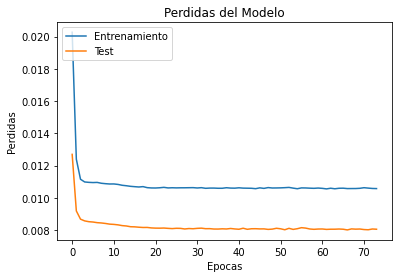

In [14]:
plt.figure(1)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Perdidas del Modelo')
plt.ylabel('Perdidas')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.show()

Puntuacion Train: 0.103 RMSE  y Puntuacion Test: 0.09 RMSE
media -0.00854235446634837
desviacion 0.0892950554124224


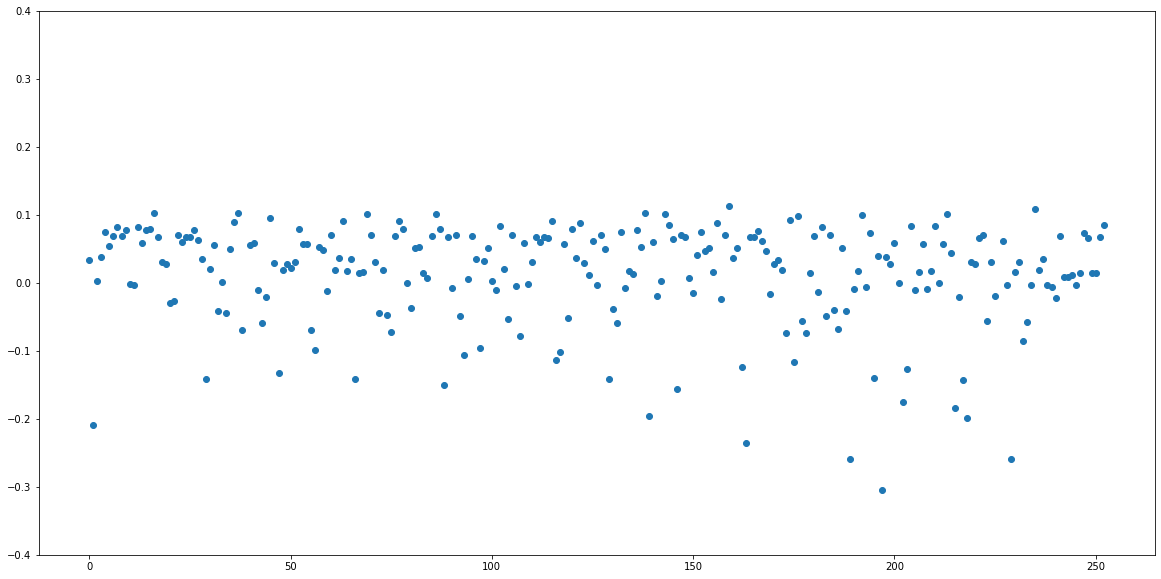

In [15]:
# Realizacion de predicciones
prediciones_entrenamiento = modelo.predict(X_train_).reshape(Y_train.shape[0])
prediciones_test = modelo.predict(X_validation_).reshape(Y_validation.shape[0])

# Inversion de las predicciones para calcular su error
#prediciones_entrenamiento = escalado.inverse_transform(prediciones_entrenamiento)
#tY = escalado.inverse_transform([tY])
#prediciones_test = escalado.inverse_transform(prediciones_test)
#testY = escalado.inverse_transform([testY])

# Calculo de la raiz del error cuadratico medio o RMSE
Puntuacion_Train = math.sqrt(mean_squared_error(Y_train, prediciones_entrenamiento))
Puntuacion_Test = math.sqrt(mean_squared_error(Y_validation, prediciones_test))

residuos = Y_validation - prediciones_test
print('Puntuacion Train: %.3f RMSE  y Puntuacion Test: %.2f RMSE' % (Puntuacion_Train, Puntuacion_Test))
print('media', np.mean(residuos))
print('desviacion', np.std(residuos))

plt.figure(figsize=(20,10))
plt.ylim([-0.4, 0.4])
plt.scatter(eje_x, modelo.predict(X_validation_).reshape(Y_validation.shape[0]) - Y_validation)